# Intro
In this brief analysis we are looking at the dataset of patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The dataset consists of about 58 thousand reviews. For simplicity, we will group the reviews by condition and then look at those with the largest number of reviews. [The dataset can be found here.](http://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
sns.set(color_codes=True)

TAG_RE = re.compile(r'<[^>]+>')
SPAN_TAG_PATTERN = ".*</span>.*"

In [2]:
drugs = pd.read_csv("drugsComTest_raw.tsv", sep="\t", parse_dates=["date"])

In [3]:
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_drugs(drugs):
    # we need to filter out any condition that is HTML: contains </span> tag
    #drugs.condition = [TAG_RE.sub('', condition) for condition in drugs.condition]
    filter = drugs['condition'].str.contains(SPAN_TAG_PATTERN)
    drugs.condition = drugs.condition.astype("category")
    filter.fillna(False, inplace=True)
    drugs = drugs[~filter]
    return drugs

In [4]:
drugs = preprocess_drugs(drugs)

In [5]:
average_ratings = drugs.groupby(["condition"]).rating.mean()
df = average_ratings.to_frame().dropna()
number_of_reviews = drugs.groupby(["condition"]).size()
number_of_reviews = number_of_reviews[number_of_reviews>0].to_frame()
df.reset_index(inplace=True)
number_of_reviews.reset_index(inplace=True)
df = df.merge(number_of_reviews, on="condition")
df.columns = ["condition", "rating", "number_of_reviews"]
df.set_index("condition", inplace=True)

In [6]:
useful_reviews = drugs.groupby(["condition"]).usefulCount.sum()
useful_reviews = useful_reviews.to_frame()
useful_reviews.reset_index(inplace=True)
mask = useful_reviews.condition.str.contains(SPAN_TAG_PATTERN)
useful_reviews = useful_reviews[~mask]
df = df.merge(useful_reviews, on="condition")
devs = drugs.groupby(["condition"]).rating.aggregate(np.std).to_frame()
devs.reset_index(inplace=True)
df = df.merge(devs, on="condition")
df.columns = ["condition", "rating", "number_of_reviews", "useful_count", "standard_deviation"]
df["useful_per_review"] = df.useful_count / df.number_of_reviews

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


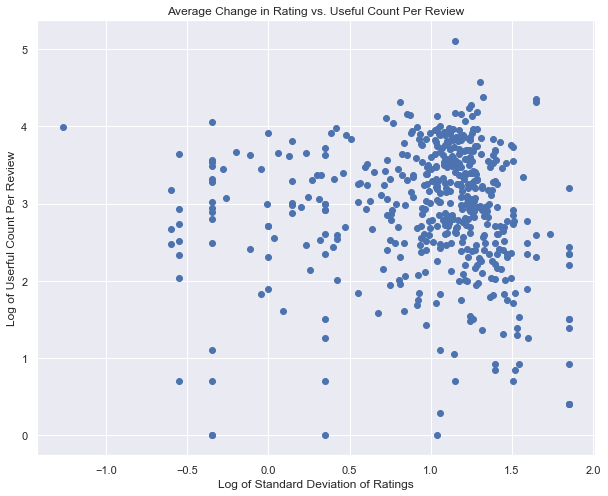

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(x=np.log(df.standard_deviation), y=np.log(df.useful_per_review))
plt.title("Average Change in Rating vs. Useful Count Per Review")
plt.xlabel("Log of Standard Deviation of Ratings")
plt.ylabel("Log of Userful Count Per Review")
plt.show()

## Predicting the rating interval
On the surface, this graphic tells us that if the reviews for a given condition fall between 20 and 54 useful count per review, the ratings will deviate by an average of 1. Therefore, if we can predict a rating for a given condition, we can also predict the interval that this rating will fall between.

In [8]:
# lets look at the distribution of number_of_ratings
df.number_of_reviews.describe()
# now lets look at the distribution of useful_count
df.useful_count.describe()
# so lets only consider those drugs with at least 6 reviews, with at least 111 useful_count
mask = (df.number_of_reviews>=6) & (df.useful_count>=111)
drugs_top_rating = df[mask].sort_values(["rating"], ascending = False)
drugs_top_rating.set_index("condition", inplace=True)
drugs_top_rating["useful_per_review"] = drugs_top_rating.useful_count / drugs_top_rating.number_of_reviews
top_drugs_per_review = drugs_top_rating.sort_values(["useful_per_review"], ascending=False)

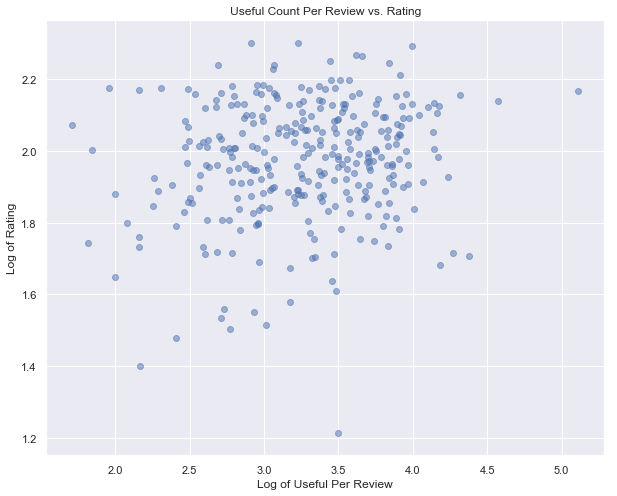

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(x=np.log(top_drugs_per_review.useful_per_review), y=np.log(top_drugs_per_review.rating), alpha=0.5)
plt.title("Useful Count Per Review vs. Rating")
plt.xlabel("Log of Useful Per Review")
plt.ylabel("Log of Rating")
plt.show()

## Predicting Rating
There does not appear to be a lot here; given this we can only predict the rating will fall between 6 and 9 when the useful count per review is between 12.2 and 54.6.

In [10]:
def plot_bar(ax, x_labels, top_labels, height_offset):
    ax.set_xticklabels(x_labels)
    rects = ax.patches
    top_labels = round(top_labels,2)
    # Make some labels.
    #labels = ["label%d" % i for i in xrange(len(rects))]
    #labels = top_conditions_by_review.head(10).number_of_reviews
    for rect, label in zip(rects, top_labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+height_offset, label,
                ha='center', va='bottom')
    return ax

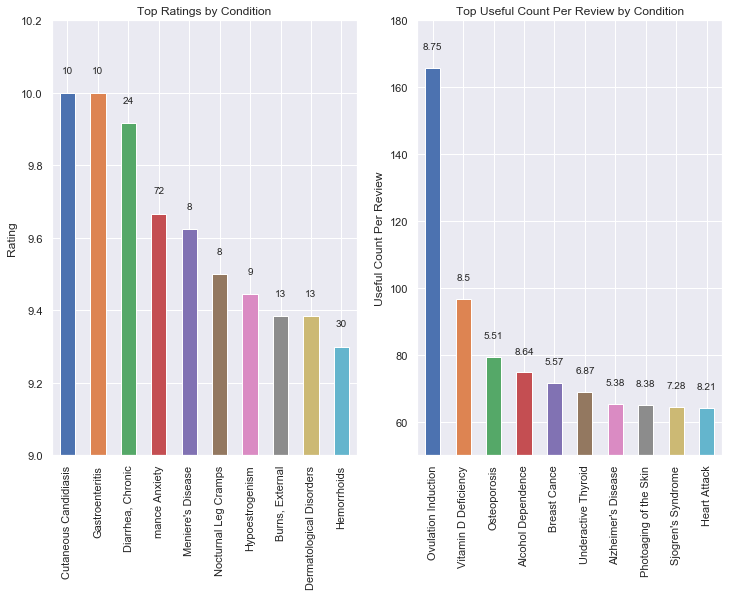

In [11]:
top_conditions_by_review = top_drugs_per_review.sort_values(["rating"], ascending=False)
top_conditions_by_useful = top_drugs_per_review.sort_values(["useful_per_review"], ascending=False)
# Bring some raw data.
ratings = top_conditions_by_review.head(10).rating
useful = top_conditions_by_useful.head(10).useful_per_review
#x_labels = top_conditions_by_review.head(10).index

# Plot the figure.
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
ax1 = ratings.plot(kind='bar')
ax1 = plot_bar(ax1, top_conditions_by_review.head(10).index, 
         top_conditions_by_review.head(10).number_of_reviews, 0.05)
ax1.set_ylim(9,10.2)
ax1.set_xlabel("")
ax1.set_ylabel("Rating")
ax1.set_title('Top Ratings by Condition')

plt.subplot(1,2,2)
ax2 = useful.plot(kind="bar")
ax2 = plot_bar(ax2, top_conditions_by_useful.head(10).index,
              top_conditions_by_useful.head(10).rating, 5)

ax2.set_xlabel("")
ax2.set_ylabel("Useful Count Per Review")
ax2.set_ylim(50,180)
ax2.set_title("Top Useful Count Per Review by Condition")
plt.show()

## Visualizing the Drug Reviews Data
I am not entirely sure how to add a "legend" to describe the text above the bars, but in the first plot it indicates the total number of reviews and in the second one it indicates the average rating. We cannot glean many insights from the first plot, however the second plot appears to show that the more people that found that review useful lead to a higher rating. 

In [12]:
top_drugs_per_review.number_of_reviews.describe()
# lets filter out our dataframe to only look at those drugs with at least 105 reviews
# remember we are already filtering out the drugs that 
# have at least 6 reviews and at least 111 people found them useful
top_drugs_per_review.useful_per_review.describe()
# we also want to add the contraint that the drug has at least 38.75 useful reviews
mask = (top_drugs_per_review.number_of_reviews>=105) & (top_drugs_per_review.useful_per_review >= 38.75)
#top_drugs_per_review[mask] 
# so there are 23 drugs that meet this criteria

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


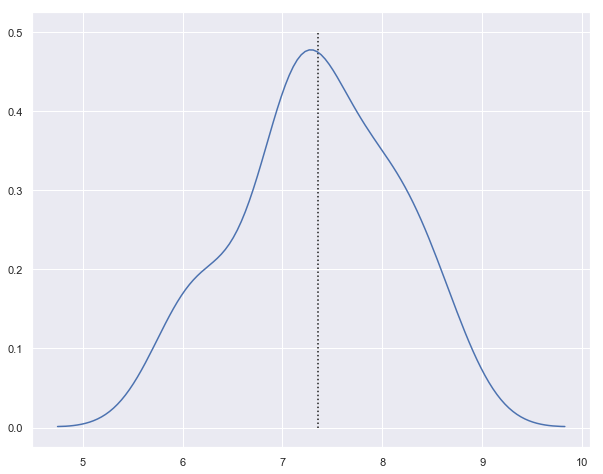

In [13]:
plt.figure(figsize=(10,8))
sns.kdeplot(top_drugs_per_review[mask].rating, legend=False)
plt.vlines(x=np.mean(top_drugs_per_review[mask].rating), ymin=-0, ymax=0.5, linestyles=[":"])
plt.show()

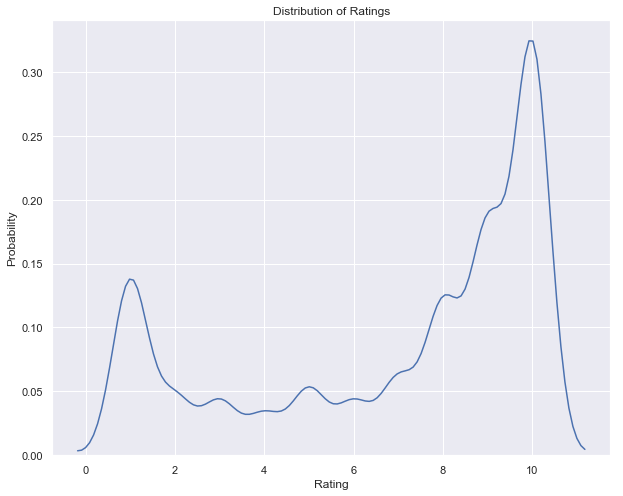

In [14]:
plt.figure(figsize=(10,8))
sns.kdeplot(drugs.rating, legend=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.show()

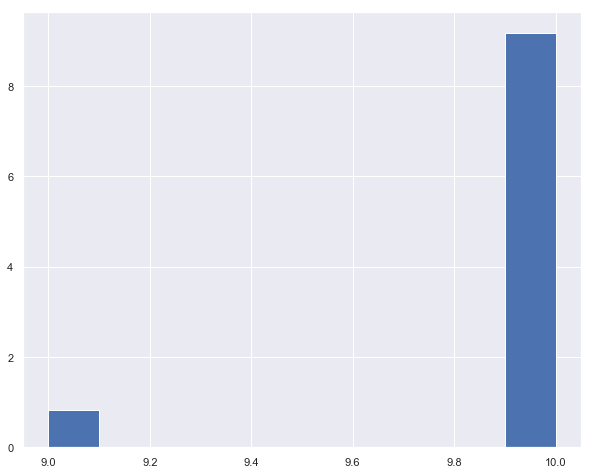

In [15]:
# just run a simple test/plot on Diarrhea, Chronic
diarrhea = drugs[drugs.condition=="Diarrhea, Chronic"]
plt.figure(figsize=(10,8))
plt.hist(diarrhea.rating, density=True)
plt.show()

In [16]:
len(top_drugs_per_review[mask])

23

# Notes
It is interesting to note that the distribution of all ratings appears to be bimodal, whereas if we take the top 23 drugs (based on the number of reviews and how useful each review is) demonstrates a normal distribution. However, if we take a deeper look at a single condition, we see that the reviews are all either high or low, with very little (if any) rating in between. If we are using this data in a prediction system, we need to account for this. [This paper discusses on such way](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2369332)